Updating data....................
BACK-TEST RESULT OF UNIFORM (1/N) ALLOCATION

#################################################################
Universe size                                                  21
Initial timestamp                       1988-01-01 00:00:00+00:00
Final timestamp                         2024-06-01 00:00:00+00:00
Number of periods                                             438
Initial value (USDOLLAR)                                1.000e+06
Final value (USDOLLAR)                                  4.017e+06
Profit (USDOLLAR)                                       3.017e+06
                                                                 
Avg. return (annualized)                                     3.9%
Volatility (annualized)                                      2.4%
Avg. excess return (annualized)                              0.8%
Excess volatility (annualized)                               2.6%
                                                              

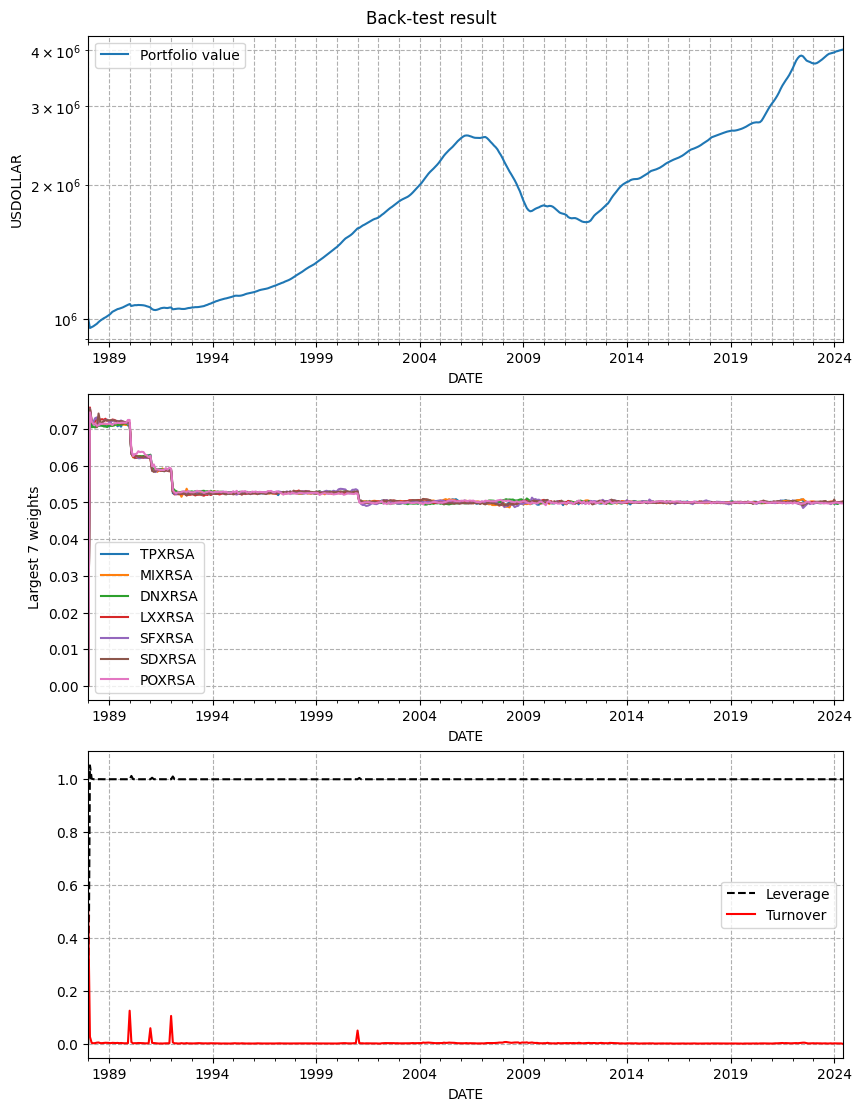

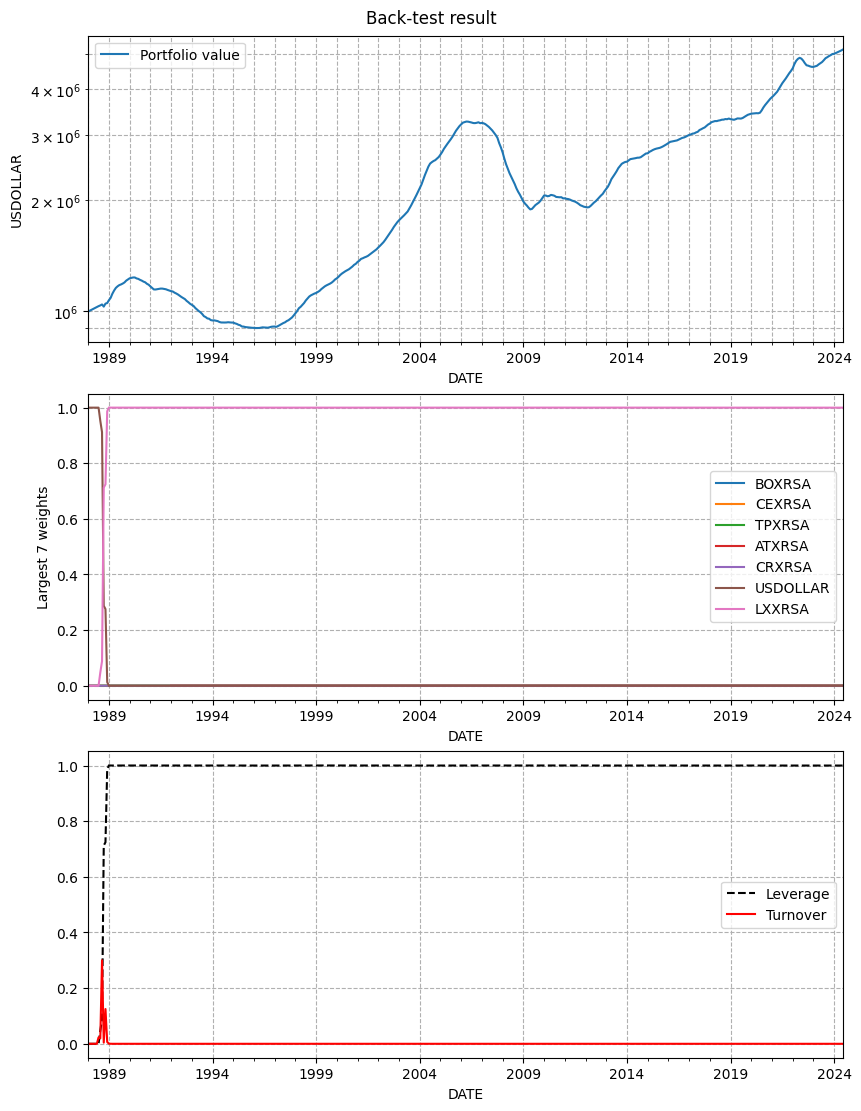

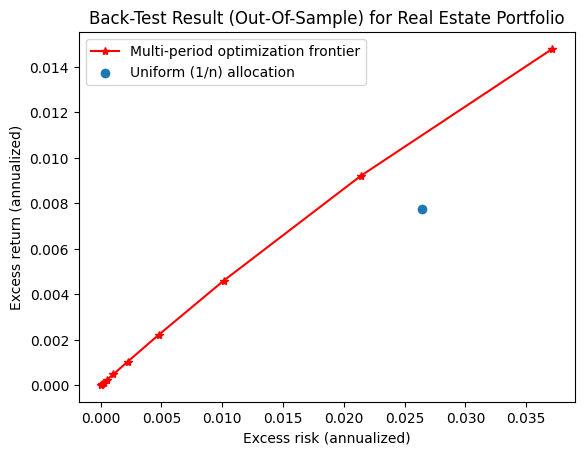

In [1]:
'''
This is an example that shows that Cvxportfolio can work as well with different asset classes,
in this case a real estate portfolio. We use the Case-Shiller index as proxy for the price of
housing units in various metropolitan areas in the USA. We impose realistic transaction costs,
which are comparable to the annual return on the asset, and we show that multi-period optimization
is useful to correctly balance transaction cost and expected risk-adjusted return. This example
script is available in the repository.
'''


import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cvxportfolio as cvx

# We test the Multi-Period Optimization model on a real estate
# portfolio for which the transaction cost are large with respect
# to the typical returns.
# We use the Case-Shiller indices as proxies for (residential) real
# estate prices.

# These are monthly time serieses of the Case-Shiller index for
# a selection of US metropolitan areas. You can find them on the
# website of FRED https://fred.stlouisfed.org/
UNIVERSE = [
    'SFXRSA', # San Francisco
    'LXXRSA', # Los Angeles
    'SEXRSA', # Seattle
    'DAXRSA', # Dallas
    'SDXRSA', # San Diego
    'MIXRSA', # Miami
    'PHXRSA', # Phoenix
    'NYXRSA', # New York
    'CHXRSA', # Chicago
    'ATXRSA', # Atlanta
    'LVXRSA', # Las Vegas
    'POXRSA', # Portland
    'WDXRSA', # Washington D.C.
    'TPXRSA', # Tampa
    'CRXRSA', # Charlotte
    'MNXRSA', # Minneapolis
    'DEXRSA', # Detroit
    'CEXRSA', # Cleveland
    'DNXRSA', # Denver
    'BOXRSA', # Boston
    ]

# we assume that the cost of transacting
# residential real estate is about 5%
LINEAR_TCOST = 0.05

simulator = cvx.MarketSimulator(
    universe = UNIVERSE,
    # we enabled the default data interface to download index
    # prices from FRED
    datasource='Fred',
    costs = [cvx.TransactionCost(
        a=LINEAR_TCOST,
        b=None, # since we don't have market volumes, we can't use the
                # market impact term of the transaction cost model
        )]
    )

# let's see what a uniform allocation does
result_uniform = simulator.backtest(cvx.Uniform())
print('BACK-TEST RESULT OF UNIFORM (1/N) ALLOCATION')
print(result_uniform)

result_uniform.plot()
if 'CVXPORTFOLIO_SAVE_PLOTS' in os.environ:
    plt.savefig('case_shiller_uniform.png')

# These are risk model coefficients. They don't seem to have
# a strong effect on this example.
NUM_FACTORS = 5
kappa = 0.1

# This is the multi-period planning horizon. We plan for 6 months
# in the future.
HORIZON = 6

policies = []

# sweep over risk aversion
for gamma_risk in np.logspace(0, 3, 10):
    policies.append(cvx.MultiPeriodOptimization(
        cvx.ReturnsForecast() - gamma_risk * (
        cvx.FactorModelCovariance(num_factors=NUM_FACTORS)
        + kappa * cvx.RiskForecastError())
             - cvx.TransactionCost(a=LINEAR_TCOST, b=None),
                 [cvx.LongOnly(applies_to_cash=True)],
                     planning_horizon=HORIZON,
             )
        )

results = simulator.backtest_many(policies)

print('BACK-TEST RESULT OF MPO WITH HIGHEST (OUT-OF-SAMPLE) PROFIT')
print(results[np.argmax([el.profit for el in results])])

results[np.argmax([el.profit for el in results])].plot()
if 'CVXPORTFOLIO_SAVE_PLOTS' in os.environ:
    plt.savefig('case_shiller_highest_profit.png')

# Plot
fig = plt.figure()
plt.plot(
    [result.excess_returns.std() * np.sqrt(12) for result in results],
    [result.excess_returns.mean() * 12 for result in results],
    'r*-',
    label='Multi-period optimization frontier'
    )
plt.scatter([result_uniform.excess_returns.std() * np.sqrt(12)],
    [result_uniform.excess_returns.mean() * 12],
    label='Uniform (1/n) allocation'
    )
plt.legend()
plt.title('Back-Test Result (Out-Of-Sample) for Real Estate Portfolio')
plt.xlabel('Excess risk (annualized)')
plt.ylabel('Excess return (annualized)')

if 'CVXPORTFOLIO_SAVE_PLOTS' in os.environ:
    fig.savefig('case_shiller_frontier.png')
else:
    plt.show()